# Create Aggregated Map Service

This notebook demonstrates how to create custom aggregated map services that can be used to visualize large volumes of track data in near-realtime. This is only support on ArcGIS Enterprise.

In [1]:
import arcgis
import datetime
import re
from arcgis.apps.tracker import TrackView

#### Connect to the GIS and access a track view

In [2]:
gis = arcgis.gis.GIS("https://server.domain/portal", "username", verify_cert=False)
track_view = TrackView(gis.content.get("711e950660fc41a592bf3f84fcf179cd"))

Enter password: ········


#### Let's display the tracks


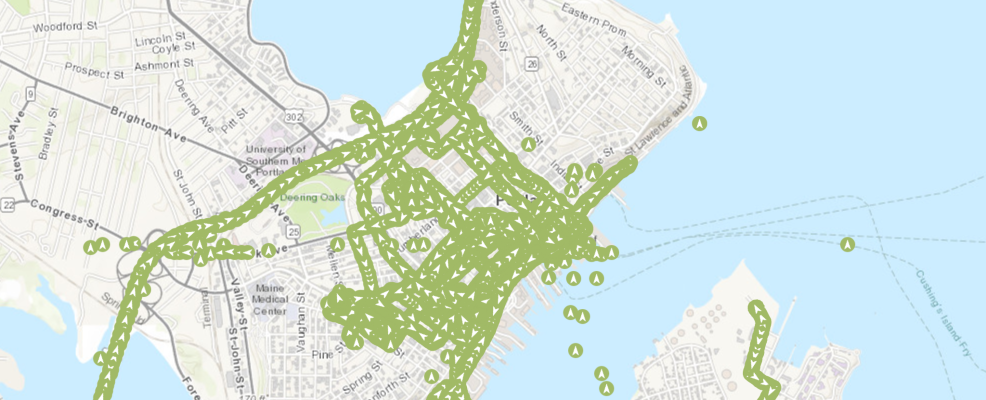

In [3]:
webmap = gis.map("Portland, ME", zoomlevel=14)
webmap.add_layer(track_view.tracks_layer)
webmap

As you can see, it's pretty difficult to extract much information from that map due to the amount of overlapping track data.

#### Define a function to create the map service

This function will allow specific customizations of the map service including:
- name
- statistics
- geohash style
- colors
- defintition expression

In [4]:
def create_map_service(track_view, name=None, statistics=None, geohash_style="flatHexagon", min_color=None,
                       max_color=None, definition_expression=None, max_value=None, min_value=None, feature_threshold=100):
    """
        Creates an aggregated map service from a track view
        :param track_view: The track view object referencing the track data
        :param name: The name of the new item to create
        :param statistics: An optional dictionary of statistics to use
        :param geohash_style: The geohash style to use, options in include "geohash", "flatHexagon", "pointyHexagon", "flatTriangle", "pointyTriangle", and "square"
        :param min_color: The minimum color to use in the color ramp. List of values between 0-255, [R, G, B, A]
        :param max_color: The maximum color to use in the color ramp. List of values between 0-255, [R, G, B, A]
        :param definition_expression: The definition expression used to limit the data returned
        :param max_value: The maximum value to use in the renderer
        :param min_value: The minimum value to use in the renderer
        :param feature_threshold: The threshold that determines if the data is aggregated or if raw features are rendered
        :return: A new item representing the map service
    """
    flc = arcgis.features.FeatureLayerCollection.fromitem(track_view.item)
    ms_definition = flc.manager._generate_mapservice_definition()
    if name is None:
        name = re.sub(r'[\W_]+', '_', track_view.item['title']) + str(int(datetime.datetime.now().timestamp()))
    if definition_expression:
        ms_definition["jsonProperties"]["layers"][0]["definitionExpression"] = definition_expression
    ms_definition['serviceName'] = name
    if statistics:
        ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["fieldStatistic"] = statistics
    if min_color:
        ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["binRenderer"]["minColor"] = min_color
    if max_color:
        ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["binRenderer"]["maxColor"] = max_color
    if max_value:
        ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["binRenderer"]["maxValue"] = max_value
    if min_value:
        ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["binRenderer"]["minValue"] = min_value
    ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["geoHashStyle"]["style"] = geohash_style
    ms_definition["jsonProperties"]["layers"][0]["drawingInfo"]["renderer"]["featureThreshold"] = feature_threshold
    new_item = track_view.item.publish(file_type="featureService", output_type="bdsMapService",
                                       publish_parameters=ms_definition)
    new_item.update({
        "title": name
    })
    return new_item

#### Create an aggregated count map service

In this example we'll create a map service that aggregates the track points into hexagons and styles the hexagons based on the number of features that intersect the hexagon. We're going to use a blue color ramp and only include mobile users that are part of the track view.


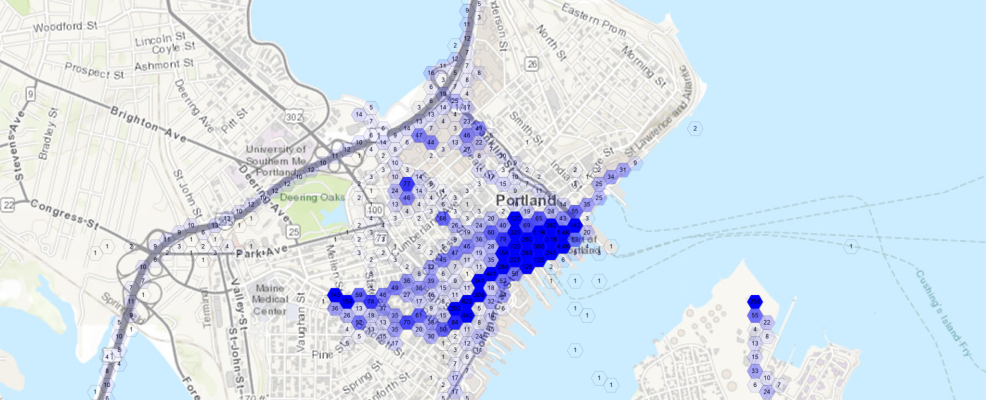

In [5]:
count_item = create_map_service(track_view,
                                 name=f"count_{int(datetime.datetime.now().timestamp())}",
                                 min_color=[0, 0, 255, 0],
                                 max_color=[0, 0, 255, 255],
                                 max_value=100,
                                 definition_expression=track_view.mobile_users.view_definition_query,
                                 feature_threshold=1)
webmap = gis.map("Portland, ME", zoomlevel=14)
webmap.add_layer(arcgis.mapping.MapImageLayer(count_item.url, gis))
webmap

The dark blue areas represent areas with the most track points. In this case there is a lot of data around our Portland, ME office.

#### Create an aggregated average accuracy map service

In this next example, we're going to use a red color ramp, filter out very inaccurate data, and then apply a statistic so that the resulting map service shows the average accuracy of our track data.


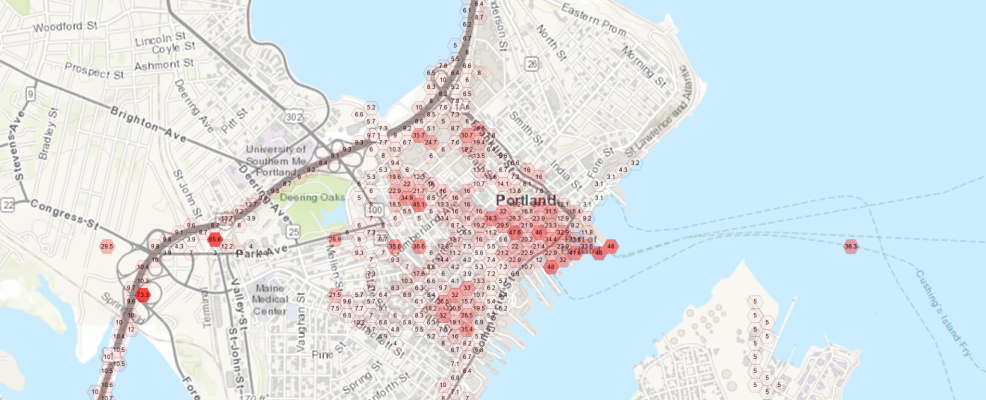

In [6]:
accuracy_item = create_map_service(track_view,
                                 name=f"count_{int(datetime.datetime.now().timestamp())}",
                                 min_color=[255, 0, 0, 0],
                                 max_color=[255, 0, 0, 255],
                                 max_value=100,
                                 min_value=0,
                                 statistics={
                                     "fieldName": "horizontal_accuracy",
                                     "statisticType": "avg"
                                 },
                                 definition_expression=f"{track_view.mobile_users.view_definition_query} AND horizontal_accuracy <= 100",
                                 feature_threshold=1)
webmap = gis.map("Portland, ME", zoomlevel=14)
webmap.add_layer(arcgis.mapping.MapImageLayer(accuracy_item.url, gis))
webmap

The bright red areas have poorer accuracy.